<a href="https://colab.research.google.com/github/Jitmandal051004/Pytorch-Practice-Project/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialization

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jitmandal24
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:08<00:00, 88.9MB/s]


In [3]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### Image Encoding

In [5]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
print(data_df["labels"].unique())
data_df.head()

['cat' 'wild' 'dog']


,image_path,labels
0,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
1,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
2,/content/animal-faces/afhq/val/cat/flickr_cat_...,cat
3,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
4,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat


In [6]:
train = data_df.sample(frac = 0.7)
test = data_df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(f'''train.shape : {train.shape}
test.shape : {test.shape}
val.shape : {val.shape}''')

train.shape : (11291, 2)
test.shape : (2419, 2)
val.shape : (2420, 2)


In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

### Custom Dataset

In [27]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [28]:
train_dataset = CustomImageDataset(train, transform)
test_dataset = CustomImageDataset(test, transform)
val_dataset = CustomImageDataset(val, transform)

In [29]:
train_dataset.__len__()

11291

In [30]:
train_dataset.__getitem__(51)

(tensor([[[0.2000, 0.2000, 0.2392,  ..., 0.3451, 0.3373, 0.3255],
          [0.1961, 0.2039, 0.2392,  ..., 0.3608, 0.3608, 0.3490],
          [0.1961, 0.2000, 0.2392,  ..., 0.3686, 0.3725, 0.3647],
          ...,
          [0.7725, 0.7765, 0.7686,  ..., 0.8667, 0.8588, 0.8588],
          [0.8000, 0.8039, 0.8078,  ..., 0.8627, 0.8510, 0.8510],
          [0.8157, 0.8235, 0.8275,  ..., 0.8588, 0.8510, 0.8510]],
 
         [[0.2000, 0.2078, 0.2549,  ..., 0.3882, 0.3804, 0.3686],
          [0.2000, 0.2118, 0.2588,  ..., 0.4039, 0.4039, 0.3922],
          [0.2000, 0.2078, 0.2549,  ..., 0.4118, 0.4157, 0.4078],
          ...,
          [0.8353, 0.8392, 0.8314,  ..., 0.9137, 0.9059, 0.9059],
          [0.8627, 0.8667, 0.8706,  ..., 0.9098, 0.8980, 0.8980],
          [0.8784, 0.8863, 0.8902,  ..., 0.9059, 0.8980, 0.8980]],
 
         [[0.2235, 0.2353, 0.2902,  ..., 0.4118, 0.4039, 0.3922],
          [0.2196, 0.2392, 0.2902,  ..., 0.4275, 0.4275, 0.4157],
          [0.2196, 0.2392, 0.2902,  ...,

In [31]:
label_encoder.inverse_transform([1])

array(['dog'], dtype=object)

### Visualization of the dataset

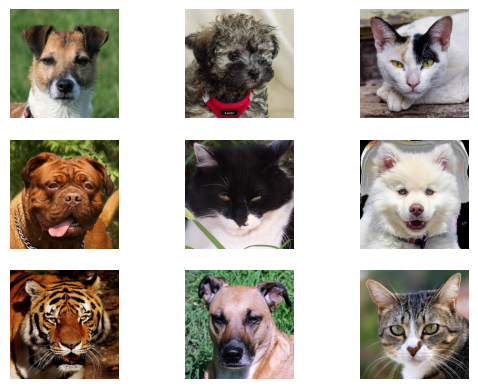

In [32]:
n_rows = 3
n_cols = 3


f, ax = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
    ax[row, col].imshow(image)
    ax[row, col].axis("off")

plt.show()

In [33]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [34]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

### Network

In [22]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # padding ensure we dont loose any kind of feature
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16), 128)

    self.output = nn.Linear(128, len(data_df["labels"].unique()))

  def forward(self, x):
    x = self.conv1(x) # -> (32, 128, 128)
    x = self.pooling(x) # -> (32, 64, 64) pooling layer doesnt reduces amount of feature but reduces the size of the feature
    x = self.relu(x) # only change the numbers in the matrix

    x = self.conv2(x) # -> (64, 64, 64)
    x = self.pooling(x) # -> (64, 32, 32)
    x = self.relu(x)

    x = self.conv3(x) # -> (128, 32, 32)
    x = self.pooling(x) # -> (128, 16, 16)
    x = self.relu(x)

    x = self.flatten(x) # convert matrix to vector
    x = self.linear(x)
    x = self.output(x)

    return x

In [23]:
model = Net().to(device)

In [24]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [25]:
criterion = nn.CrossEntropyLoss() # in case of binary result we use binaryEntropy
optimizer = Adam(model.parameters(), lr = LR)

In [ ]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step() # optimizs the value of model

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train / 1000, 4))
  total_loss_val_plot.append(round(total_loss_val / 1000, 4))

  total_acc_train_plot.append(round((total_acc_train / train_dataset.__len__()) * 100, 4))
  total_acc_val_plot.append(round((total_acc_val / val_dataset.__len__()) * 100, 4))

  print(f'''Epoch : {epoch+1}
            Train Loss : {total_loss_train_plot[-1]} , Train Acc : {total_acc_train_plot[-1]}
            Val Loss : {total_loss_val_plot[-1]} , Val Acc : {total_acc_val_plot[-1]}
        ''')

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labelsin test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f'''Accuracy score is: {round((total_acc_test / test_dataset.__len__()) * 100, 4)}
Loss is {round(total_loss_test / 1000, 4)}''')